# Setup

## Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os

# CAMINHOS IMPORTANTES:
GOOGLE_DRIVE_PATH_PROJETO = '/content/drive/My Drive/PLN/Projeto' # alterar conforme a organização dos seus diretórios

os.chdir(GOOGLE_DRIVE_PATH_PROJETO)

df_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'dfs')
if not os.path.exists(df_path):
  print(f"Diretório de DataFrames não encontrada em: {df_path}. Criando agora.")
  os.makedirs(df_path)
else:
  print(f"Diretório de DataFrames encontrado em: {df_path}")

figs_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'figs')
if not os.path.exists(figs_path):
  print(f"Diretório de figuras não encontrada em: {figs_path}. Criando agora.")
  os.makedirs(figs_path)
else:
  print(f"Diretório de figuras encontrado em: {figs_path}")

models_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'models')
if not os.path.exists(models_path):
  print(f"Diretório de modelos não encontrado em: {models_path}. Criando agora.")
  os.makedirs(models_path)
else:
  print(f"Diretório de modelos encontrado em: {models_path}")

Diretório de DataFrames encontrado em: /content/drive/My Drive/PLN/Projeto/dfs
Diretório de figuras encontrado em: /content/drive/My Drive/PLN/Projeto/figs
Diretório de modelos encontrado em: /content/drive/My Drive/PLN/Projeto/models


In [ ]:
# Testando acesso aos diretórios
files = os.listdir(os.getcwd())
for file in files:
  print(file)

essay-br
figs
.ipynb_checkpoints
dfs
__pycache__
models
utils2.py
Competencia_2.ipynb


Estrutura esperada:
```
projeto/
├── essay-br/               # dataset clonado do github dos autores
├── dfs/                    # dataframes de dados processados relevantes
│   └── <dataframes>.csv
├── figs/                   # gráficos relevantes
│   └── <figs>.png
├── models/                 # modelos (classifiers, vectorizers, etc)
│   └── <models>.joblib
├── utils2.py                # funções auxiliares
└── competencia2.ipynb      # este notebook
```

## Dependências

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # para salvar e carregar modelos treinados

# Carregamento e visualização dos dados

O corpus foi obtido no [repositório oficial do paper Essay-BR](https://github.com/lplnufpi/essay-br).


Os dados são fornecidos organizados da seguinte maneira:
- `essay-br.csv`:
    - `prompt`: referência à `id` do conjunto `prompts`
    - `title`: título da redação
    - `essay`: lista de parágrafos da redação
    - `c1` ... `c5`: pontuação referente a cada competência do Enem
    - `score`: nota final dada pela soma das pontuações obtidas em cada competência
- `prompts.csv`:
    - `id`: identificador do tema
    - `title`: título do texto motivador
    - `description`: texto motivador
    - `category`: categoria do tema - sociedade e cultura, economia, política, ciência e tecnologia, meio ambiente, educação, segurança e saúde.

Realizando a clonagem do repositório no ambiente do Colab e copiando-o para o diretório apropriadono Google Drive:

In [ ]:
!git clone https://github.com/lplnufpi/essay-br.git

In [ ]:
import shutil

repository_name = 'essay-br'
source_path_in_colab = os.path.join('/content', repository_name)
destination_path_in_drive = os.getcwd()

try:
  if os.path.exists(source_path_in_colab):
    shutil.copytree(source_path_in_colab, os.path.join(destination_path_in_drive, repository_name))
    print(f"O repositório '{repository_name}' foi copiado para o Google Drive em: {destination_path_in_drive}.")
  else:
    if repository_name in os.listdir(destination_path_in_drive):
      print(f"O repostório '{os.path.join(destination_path_in_drive, repository_name)}' já foi clonado no Google Drive.")
    else:
      print(f"Erro: O diretório '{source_path_in_colab}' não foi encontrado.")

except FileExistsError:
  print(f"O diretório '{os.path.join(destination_path_in_drive, repository_name)}' já existe no Google Drive.")
except FileNotFoundError:
  print(f"Erro: O diretório de origem '{source_path_in_colab}' não foi encontrado.")
except Exception as e:
  print(f"Ocorreu um erro ao copiar o repositório: {e}")


Realizando a instalação das dependências do Corpus:

In [ ]:
!pip install -r essay-br/requirements.txt

Carregando, separando em conjuntos de treino, validação e teste e visualizando os dados:

In [ ]:
import sys

# Certifica que o diretório do repositório está no PATH do Python
repository_dir = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'essay-br')
if repository_dir not in sys.path:
  sys.path.append(repository_dir)

from build_dataset import Corpus

original_dir = os.getcwd()
print(f"Diretório de trabalho atual (antes): {original_dir}")
try:
  # Mudar para o diretório do repositório para facilitar o acesso aos arquivos
  repo_current_dir = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'essay-br')
  os.chdir(repo_current_dir)
  print(f"Diretório de trabalho alterado para: {os.getcwd()}")
  c = Corpus()

  # Define o caminho onde os splits são salvos por padrão
  splits_dir = os.path.join(repo_current_dir, 'extended-corpus', 'splits')
  train_split_path = os.path.join(splits_dir, 'train.csv')
  valid_split_path = os.path.join(splits_dir, 'dev.csv')
  test_split_path = os.path.join(splits_dir, 'test.csv')

  # Verifica se os arquivos de split já existem
  if not (os.path.exists(train_split_path) and os.path.exists(valid_split_path) and os.path.exists(test_split_path)):
    print("\n\nSplits do dataset não encontrados. Construindo os splits...")
    c.build_corpus('extended_essay-br.csv')
    # por defualt, build_corpus utiliza uma função de split com:
    # 70% treino, 15% validação e 15% teste
    # e salva os arquivos .csv de cada partição em extended-corpus/splits
    print("Splits construídos com sucesso!")
  else:
    print("\n\nSplits do dataset já existem. Pulando a etapa de construção.")

  print("Lendo os splits do dataset...")
  train_df, valid_df, test_df = c.read_splits()
  print("Splits carregados com sucesso!")

  print(f"\nDados de treinamento: {train_df.shape}")
  display(train_df.head())
  print(f"\nDados de validação: {valid_df.shape}")
  display(valid_df.head())
  print(f"\nDados de teste: {test_df.shape}")
  display(test_df.head())

  print("\n\nCarregando prompts...")
  prompts_df = c.read_corpus('prompts.csv')
  print("Prompts carregados com sucesso!")

  print(f"\nPrompts: {prompts_df.shape}")
  display(prompts_df.head())

except Exception as e:
  print(f"Ocorreu um erro: {e}")

finally:
  # Restaurar o diretório de trabalho original
  os.chdir(original_dir)
  print(f"\n\nDiretório de trabalho restaurado para: {os.getcwd()}")

Diretório de trabalho atual (antes): /content/drive/My Drive/PLN/Projeto
Diretório de trabalho alterado para: /content/drive/My Drive/PLN/Projeto/essay-br


Splits do dataset já existem. Pulando a etapa de construção.
Lendo os splits do dataset...
Splits carregados com sucesso!

Dados de treinamento: (4603, 9)


,prompt,title,essay,c1,c2,c3,c4,c5,score
0,86,Bem está mental,[É notório que as redes sociais estão cada vez...,120,120,120,160,160,680
1,86,A questão das redes sociais na saúde mental da...,[Com o avanço das tecnologias ao redor do mund...,200,160,160,200,160,880
2,47,Democratização do ensino remoto no Brasil,[A declaração universal dos direitos humanos a...,160,160,160,160,160,800
3,89,"ZZZ (POR FAVOR, IGNOREM O TAMANHO, PRECISO DA ...","[Barão de Itararé, um dos criadores do jornali...",160,160,160,200,200,880
4,40,Um samba enredo que está por vir,"[No carnaval deste ano, a escola de samba Uniã...",160,160,120,200,200,840



Dados de validação: (987, 9)


,prompt,title,essay,c1,c2,c3,c4,c5,score
0,128,O papel do meio ambiente na riqueza de um país,[Para ser ter um bom desenvolvimento econômico...,120,80,80,80,80,440
1,93,NaN,[EM CONSONÂNCIA COM A DECLARAÇÃO UNIVERSAL DOS...,120,120,120,160,120,640
2,92,Não ao preconceito amarelo,"[A Declaração Universal de Direitos Humanos , ...",160,160,160,200,160,840
3,71,"Suicidío, problema ou solução?",[O suicidío depende do ponto de vista de cada ...,120,80,80,80,80,440
4,66,NaN,[Dos anos noventa até os dias atuais a tecnolo...,120,80,80,80,80,440



Dados de teste: (987, 9)


,prompt,title,essay,c1,c2,c3,c4,c5,score
0,58,O planeta precisa de você,[A Amazônia é um bioma importantíssimo para o ...,120,80,80,120,40,440
1,50,Belicismo científico,"[No famoso Anime ""Naruto"", o personagem antago...",160,160,160,160,120,760
2,82,NaN,[O hábito do automedicação está presente na vi...,120,160,160,120,160,720
3,58,Consumismo e Meio Ambiente,[Muitas são as mudanças percebidas a partir da...,160,80,40,120,40,440
4,95,Debate sobre o marco temporal,[De acordo com artigo 231 da Constituição fede...,160,120,120,160,160,720




Carregando prompts...
Prompts carregados com sucesso!

Prompts: (151, 4)


,id,title,description,category
0,0,Carnaval e apropriação cultural,"['No Carnaval de 2020, veio novamente à tona u...",sociedade e cultura
1,1,Qualificação e o futuro do emprego,['O número de pessoas desempregadas no mundo d...,economia
2,2,Supremo Tribunal Federal e opinião pública,"['Ao longo dos últimos dez anos, o papel do ST...",política
3,3,"Ciência, tecnologia e superação dos limites hu...","['Com o avanço da biotecnologia, da engenharia...",ciência e tecnologia
4,4,Um réu deve ou não ser preso após a condenação...,"['No início deste mês de novembro, o Supremo T...",sociedade e cultura




Diretório de trabalho restaurado para: /content/drive/My Drive/PLN/Projeto


### Pré-processamento

In [ ]:
# Removendo colunas irrelevantes para a Competência II
train_df.drop(['title', 'c1', 'c3', 'c4', 'c5', 'score'], axis=1, inplace=True)
valid_df.drop(['title', 'c1', 'c3', 'c4', 'c5', 'score'], axis=1, inplace=True)
test_df.drop(['title', 'c1', 'c3', 'c4', 'c5', 'score'], axis=1, inplace=True)

# Remover linhas sem redação
train_df = train_df[train_df['essay'].apply(lambda x: len(x) > 0)].copy()
valid_df = valid_df[valid_df['essay'].apply(lambda x: len(x) > 0)].copy()
test_df = test_df[test_df['essay'].apply(lambda x: len(x) > 0)].copy()

# Pré-processamento: juntar parágrafos em uma única string para a redação
train_df['essay_text'] = train_df['essay'].apply(lambda x: ' '.join(x))
valid_df['essay_text'] = valid_df['essay'].apply(lambda x: ' '.join(x))
test_df['essay_text'] = test_df['essay'].apply(lambda x: ' '.join(x))

# Competência II

- **200 pontos**: Desenvolve o tema por meio de argumentação consistente, a partir de um repertório sociocultural produtivo, e apresenta excelente domínio do texto dissertativo-argumentativo.

- **160 pontos**: Desenvolve o tema por meio de argumentação consistente e apresenta bom domínio do texto dissertativo-argumentativo, com proposição,
argumentação e conclusão.

- **120 pontos**: Desenvolve o tema por meio de argumentação previsível e apresenta domínio mediano do texto dissertativo-argumentativo, com proposição,
argumentação e conclusão.

- **80 pontos**: Desenvolve o tema recorrendo à cópia de trechos dos textos motivadores ou apresenta domínio insuficiente do texto dissertativo-argumentativo, não atendendo à estrutura com proposição, argumentação e conclusão.

- **40 pontos**: Apresenta o assunto, tangenciando o tema, ou demonstra domínio precário do texto dissertativo-argumentativo, com traços constantes de outros tipos textuais.

- **0 ponto**: Fuga ao tema/não atendimento à estrutura -dissertativo-argumentativa. Nestes casos a redação recebe nota zero e é anulada


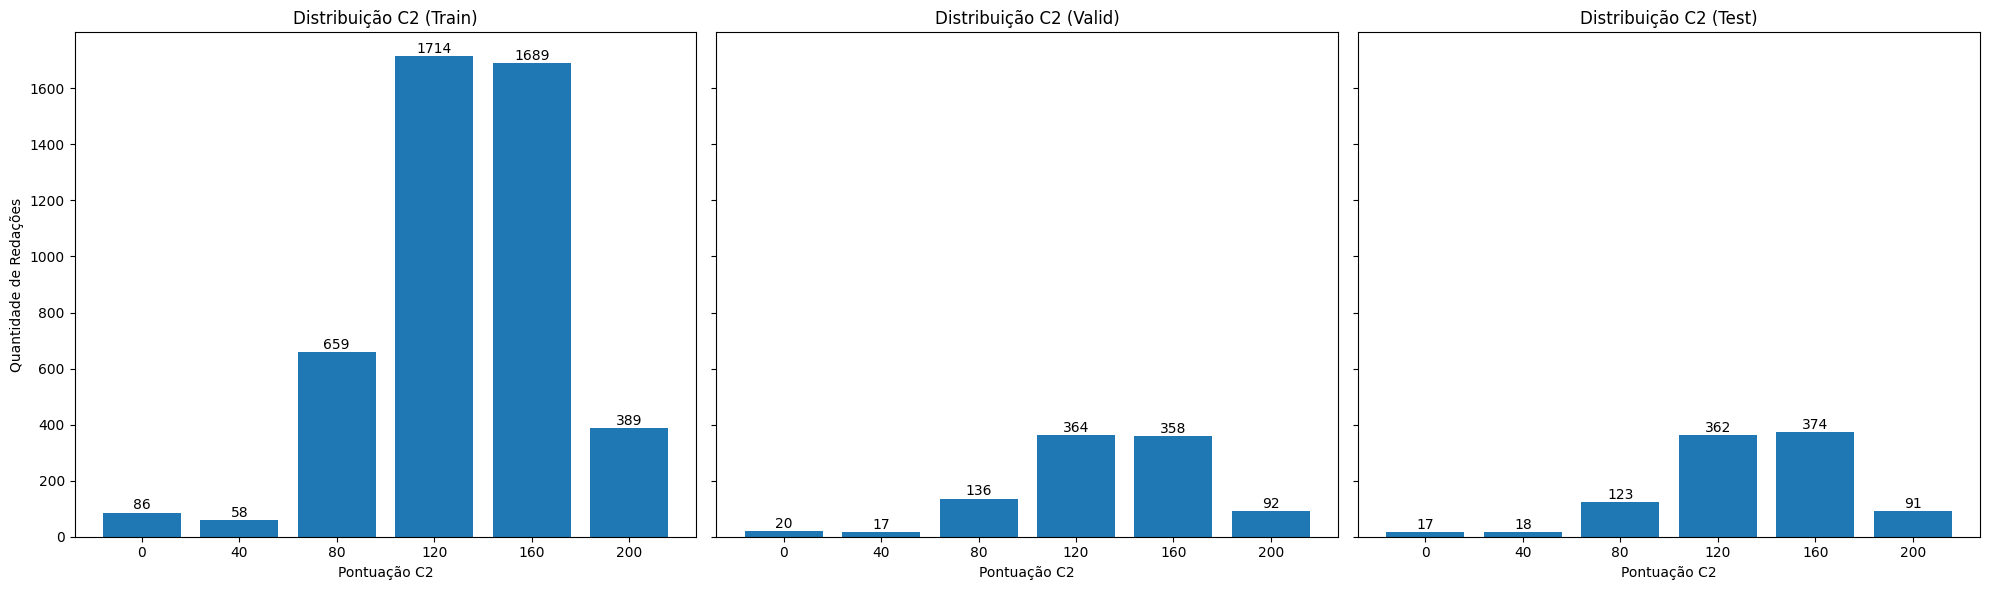

In [ ]:
dfs = [
    (train_df, 'Train'),
    (valid_df, 'Valid'),
    (test_df, 'Test')
]


fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True) # sharey=True para alinhar os eixos Y

for i, (df, title_suffix) in enumerate(dfs):
    ax = axes[i]

    # Contagem de redações por faixa de C2
    c2_counts = df['c2'].value_counts().sort_index()

    # Plot
    bars = ax.bar(c2_counts.index.astype(str), c2_counts.values)
    ax.set_title(f'Distribuição C2 ({title_suffix})')
    ax.set_xlabel('Pontuação C2')

    # Adiciona o valor acima de cada barra
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
                ha='center', va='bottom')
axes[0].set_ylabel('Quantidade de Redações')

plt.tight_layout()

# Salva a figura
plt.savefig('figs/essay_by_c2.png')
plt.show()

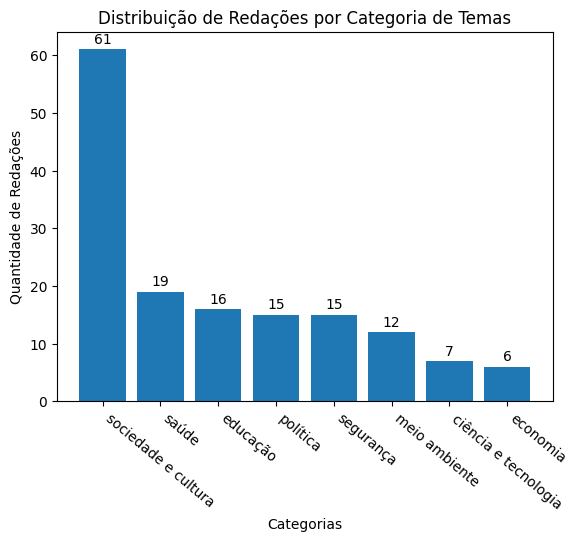

In [ ]:
# Contagem de redações por categoria
category_counts = prompts_df.loc[prompts_df['id'].isin(train_df['prompt']), 'category'].value_counts()

# Plot
bars = plt.bar(category_counts.index, category_counts.values)
plt.title('Distribuição de Redações por Categoria de Temas')
plt.xlabel('Categorias')
plt.ylabel('Quantidade de Redações')
plt.xticks(rotation=-40, ha='left') # rotaciona o eixo x dos rótulos

# Adiciona o valor acima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
             ha='center', va='bottom')

plt.savefig('figs/essay_by_prompt_category.png')
plt.show()

## Adequação do texto ao gênero dissertativo-argumentativo

Treina um modelo de Regressão Logística simples com os dados rotulados como dissertativo-argumentativo (c2 >= 160) e não dissertativo-argumentativo (c2 < 160) para calcular a probabilidade da redação estar ou não adequada ao gênero.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from utils2 import extract_paragraph_features


nv3 = 160  # pontuação em c2 que determina a adequação do texto ao gênero (para gerar rótulos do treinamento)
limiar = 0.5 # limiar de probabilidade para classificação

train_genre_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'dfs', 'train_genre_custom-feature.csv')
valid_genre_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'dfs', 'valid_genre_custom-feature.csv')
test_genre_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'dfs', 'test_genre_custom-feature.csv')

tfidf_vectorizer_genre_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'models', 'tfidf_vectorizer_genre.joblib')
scaler_model_genre_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'models', 'scaler_model_genre.joblib')
classifier_model_genre_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'models', 'classifier_model_genre.joblib')

if (os.path.exists(tfidf_vectorizer_genre_path) and
    os.path.exists(scaler_model_genre_path) and
    os.path.exists(classifier_model_genre_path) and
    os.path.exists(train_genre_path) and
    os.path.exists(valid_genre_path) and
    os.path.exists(test_genre_path)):

    print("Modelos e arquivos salvos encontrados!")
    print("Carregando vetorizador TF-IDF, scaler e modelo de classificação...")
    tfidf_vectorizer_genre = joblib.load(tfidf_vectorizer_genre_path)
    scaler_model = joblib.load(scaler_model_genre_path)
    classifier_model = joblib.load(classifier_model_genre_path)
    print("Vetorizador, scaler e modelo de classificação carregados com sucesso!")

    print(f"Carregando arquivos de previsão dos conjuntos train, valid e test...")
    train_genre_df = pd.read_csv(train_genre_path)
    valid_genre_df = pd.read_csv(valid_genre_path)
    test_genre_df = pd.read_csv(test_genre_path)
    print("Arquivos carregados!")

else:
  print("Sem modelos ou arquivos salvos. Construíndo agora...")
  # --- 1. Preparação dos Dados (pra cada DataFrame) ---
  train_genre_df = train_df.copy()
  valid_genre_df = valid_df.copy()
  test_genre_df = test_df.copy()

  train_genre_df['is_dissertativo'] = (train_genre_df['c2'] >= nv3).astype(int)
  valid_genre_df['is_dissertativo'] = (valid_genre_df['c2'] >= nv3).astype(int)
  test_genre_df['is_dissertativo'] = (test_genre_df['c2'] >= nv3).astype(int)

  X_train_text, y_train = train_genre_df['essay_text'], train_genre_df['is_dissertativo']

  # --- 2. Extração de carac: ---
  print("Extraíndo características (customizadas)...")
  train_genre_df = extract_paragraph_features(train_genre_df)
  valid_genre_df = extract_paragraph_features(valid_genre_df)
  test_genre_df = extract_paragraph_features(test_genre_df)
  print("Características customizadas extraídas!")

  print("Extraíndo características (TF-IDF)...")
  tfidf_vectorizer_genre = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
  tfidf_vectorizer_genre.fit(X_train_text)
  X_train_vec = tfidf_vectorizer_genre.transform(X_train_text)
  X_valid_vec = tfidf_vectorizer_genre.transform(valid_genre_df['essay_text'])
  X_test_vec = tfidf_vectorizer_genre.transform(test_genre_df['essay_text'])
  print("Características TF-IDF extraídas!")

  # Salvar vetorizador
  joblib.dump(tfidf_vectorizer_genre, tfidf_vectorizer_genre_path)

  # Combinar TF-IDF com as novas características
  additional_features_cols = ['num_paragraphs', 'avg_paragraph_length']

  # Normalizar atribs num
  scaler_model_genre = StandardScaler()
  X_train_additional_features = scaler_model_genre.fit_transform(train_genre_df[additional_features_cols].values)
  X_valid_additional_features = scaler_model_genre.transform(valid_genre_df[additional_features_cols].values)
  X_test_additional_features = scaler_model_genre.transform(test_genre_df[additional_features_cols].values)

  # Salvar scaler
  joblib.dump(scaler_model_genre, scaler_model_genre_path)

  # Concatenar as features TF-IDF (esparsas) com as novas features (densas)
  X_train_combined = hstack([X_train_vec, X_train_additional_features])
  X_valid_combined = hstack([X_valid_vec, X_valid_additional_features])
  X_test_combined = hstack([X_test_vec, X_test_additional_features])

  # --- 3. Modelo de Classificação: Regressão Logística ---
  print("Treinando classificador (Regressão Logística)...")
  classifier_model_genre = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
  classifier_model_genre.fit(X_train_combined, y_train)
  print("Treino concluído!")

  # Salvar modelo de classificação
  joblib.dump(classifier_model_genre, classifier_model_genre_path)

  # Calculando as probs para o conjunto de treino
  print("Calculando probabilidade do conjunto de treino...")
  y_train_proba = classifier_model_genre.predict_proba(X_train_combined)[:, 1]
  train_genre_df['is_dissertativo_prob'] = y_train_proba
  print("Probabilidade calculada para treino!")

  # Calculando as probs para o conjunto de validação
  print("Calculando probabilidade do conjunto de validação...")
  y_valid_proba = classifier_model_genre.predict_proba(X_valid_combined)[:, 1]
  valid_genre_df['is_dissertativo_prob'] = y_valid_proba
  print("Probabilidade calculada para validação!")

  # Calculando as probs para o conjunto de teste
  print("Calculando probabilidade do conjunto de teste...")
  y_test_proba = classifier_model_genre.predict_proba(X_test_combined)[:, 1]
  test_genre_df['is_dissertativo_prob'] = y_test_proba
  print("Probabilidade calculada para teste!")

  # Salvar dfs
  train_genre_df.to_csv(train_genre_path, index=False)
  valid_genre_df.to_csv(valid_genre_path, index=False)
  test_genre_df.to_csv(test_genre_path, index=False)


# --- 4. Avaliação (Agora TF-IDF Vectorizer, Scaler e Classifier estão sempre disponíveis) ---
y_train = train_genre_df['is_dissertativo']
y_train_proba = train_genre_df['is_dissertativo_prob']
y_train_pred = (y_train_proba >= limiar).astype(int)

y_valid = valid_genre_df['is_dissertativo']
y_valid_proba = valid_genre_df['is_dissertativo_prob']
y_valid_pred = (y_valid_proba >= limiar).astype(int)

y_test = test_genre_df['is_dissertativo']
y_test_proba = test_genre_df['is_dissertativo_prob']
y_test_pred = (y_test_proba >= limiar).astype(int)


print("\n\n--- Relatório de Classificação (TREINO) ---")
print(classification_report(y_train, y_train_pred, target_names=['Não Dissertativo', 'Dissertativo']))

print("\n\n--- Relatório de Classificação (VALIDAÇÃO) ---")
print(classification_report(y_valid, y_valid_pred, target_names=['Não Dissertativo', 'Dissertativo']))

print("\n\n--- Relatório de Classificação (TESTE) ---")
print(classification_report(y_test, y_test_pred, target_names=['Não Dissertativo', 'Dissertativo']))

Modelos e arquivos salvos encontrados!
Carregando vetorizador TF-IDF, scaler e modelo de classificação...
Vetorizador, scaler e modelo de classificação carregados com sucesso!
Carregando arquivos de previsão dos conjuntos train, valid e test...
Arquivos carregados!


--- Relatório de Classificação (TREINO) ---
                  precision    recall  f1-score   support

Não Dissertativo       0.83      0.87      0.85      2522
    Dissertativo       0.83      0.78      0.80      2081

        accuracy                           0.83      4603
       macro avg       0.83      0.82      0.82      4603
    weighted avg       0.83      0.83      0.83      4603



--- Relatório de Classificação (VALIDAÇÃO) ---
                  precision    recall  f1-score   support

Não Dissertativo       0.75      0.79      0.77       537
    Dissertativo       0.74      0.69      0.71       450

        accuracy                           0.75       987
       macro avg       0.74      0.74      0.74       

In [ ]:
print("Adequação ao gênero:")
display(test_genre_df[['is_dissertativo', 'num_paragraphs', 'paragraph_lengths', 'avg_paragraph_length', 'is_dissertativo_prob', 'c2']].head(10))

Adequação ao gênero:


,is_dissertativo,num_paragraphs,paragraph_lengths,avg_paragraph_length,is_dissertativo_prob,c2
0,0,5,"[13, 66, 31, 22, 37]",33.80,0.132311,80
1,1,4,"[73, 116, 77, 119]",96.25,0.824973,160
2,1,4,"[43, 63, 52, 61]",54.75,0.441050,160
3,0,4,"[59, 56, 66, 63]",61.00,0.504225,80
4,0,4,"[79, 77, 42, 63]",65.25,0.492100,120
5,1,4,"[83, 116, 100, 48]",86.75,0.692243,160
6,0,4,"[77, 77, 56, 84]",73.50,0.258640,120
7,1,1,[317],317.00,0.843586,200
8,1,4,"[83, 96, 80, 79]",84.50,0.804768,160
9,0,4,"[77, 63, 53, 49]",60.50,0.194885,120


In [ ]:
print(f"Correlação entre num_paragraphs e is_dissertativo: {valid_genre_df['num_paragraphs'].corr(valid_genre_df['is_dissertativo'])}")
print(f"Correlação entre avg_paragraph_length e is_dissertativo: {valid_genre_df['avg_paragraph_length'].corr(valid_genre_df['is_dissertativo'])}")

Correlação entre num_paragraphs e is_dissertativo: 0.030596068898217133
Correlação entre avg_paragraph_length e is_dissertativo: 0.28220543224119793


### Análise da abordagem

In [ ]:
# Correlação entre probabilidade inferida e pontuação da C2
print(f"Correlação entre probabilidade inferida e C2: {valid_genre_df['is_dissertativo_prob'].corr(valid_genre_df['c2'])}")

Correlação entre probabilidade inferida e C2: 0.5526949519849276


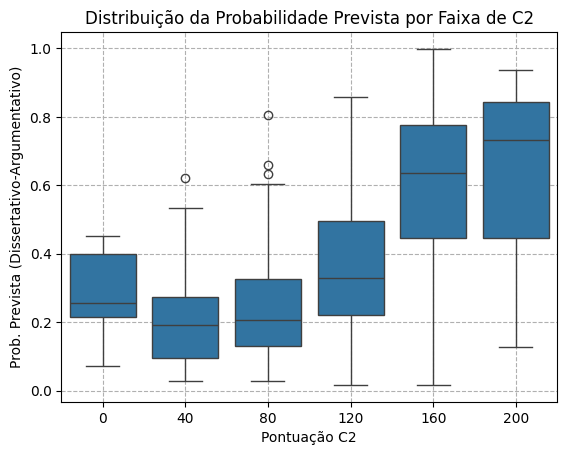

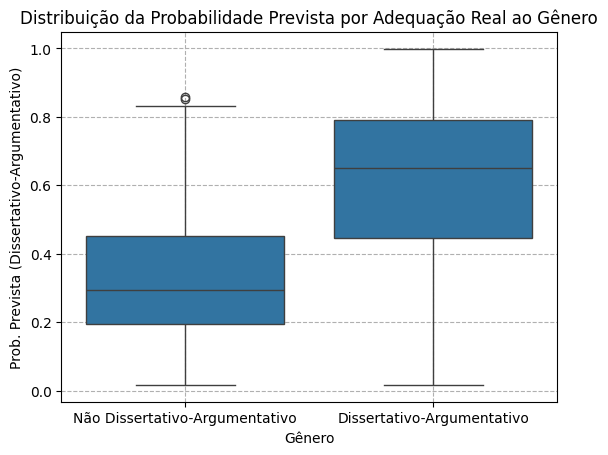

In [ ]:
# --- 1. Boxplot: is_dissertativo_prob por c2 ---
sns.boxplot(x=test_genre_df['c2'], y=test_genre_df['is_dissertativo_prob'])
plt.title("Distribuição da Probabilidade Prevista por Faixa de C2")
plt.ylabel("Prob. Prevista (Dissertativo-Argumentativo)")
plt.xlabel("Pontuação C2")
plt.grid(True, linestyle='--')
plt.savefig('figs/prob_genre_custom-feature_by_c2_boxplot.png')
plt.show()


# --- 2. Boxplot: is_dissertativo_prob por is_dissertativo ---
sns.boxplot(x=test_genre_df['is_dissertativo'], y=test_genre_df['is_dissertativo_prob'])
plt.title("Distribuição da Probabilidade Prevista por Adequação Real ao Gênero")
plt.xlabel("Gênero")
plt.ylabel("Prob. Prevista (Dissertativo-Argumentativo)")
plt.grid(True, linestyle='--')
plt.xticks(ticks=[0, 1], labels=['Não Dissertativo-Argumentativo', 'Dissertativo-Argumentativo'])
plt.savefig('figs/prob_genre_custom-feature_by_real_genre.png')
plt.show()


## Cobertura do recorte temático

Similaridade semântica entre as principais informações da redação e do prompt dado.

Utiliza representação TF-IDF da redação e do prompt na tentativa de extrair informações/palavras relevantes, gera embeddings com modelo treinado e calcula similaridade do cosseno.

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from utils2 import extract_top_keywords_tfidf, calculate_similarity_test

train_similarity_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'dfs', 'train_tf-idf-10-trigram_similarity.csv')
prompts_similarity_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'dfs', 'prompts_tf-idf-10-trigram_similarity.csv')

sbert_model_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'models', 'sbert_model.joblib')
tfidf_vectorizer_similarity_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'models', 'tfidf_vectorizer_similarity.joblib')


sbert_model = None
tfidf_vectorizer_similarity = None

if (os.path.exists(sbert_model_path) and
    os.path.exists(tfidf_vectorizer_similarity_path) and
    os.path.exists(train_similarity_path) and
    os.path.exists(prompts_similarity_path)):

    print("Modelos e arquivos salvos encontrados!")
    print("Carregando SBERT Model e TF-IDF Vectorizer...")
    try:
        sbert_model = joblib.load(sbert_model_path)
        tfidf_vectorizer_similarity = joblib.load(tfidf_vectorizer_similarity_path)
        print("SBERT Model e TF-IDF Vectorizer carregados com sucesso!")
    except Exception as e:
        print(f"Erro ao carregar modelos: {e}. Tentando recriar.")
        sbert_model = None
        tfidf_vectorizer_similarity = None

    print("Carregando arquivos de similaridade...")
    train_similarity_df = pd.read_csv(train_similarity_path)
    prompts_similarity_df = pd.read_csv(prompts_similarity_path)
    print("Arquivos carregados!")

else:
  print("Sem modelos ou arquivos salvos. Construíndo agora...")
  try:
    print("Carregando modelo SentenceTransformer...")
    sbert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    print("Modelo SentenceTransformer carregado com sucesso!")

    # Salvar modelo
    joblib.dump(sbert_model, sbert_model_path)

    # Criar um texto completo para o prompt (título + descrição)
    prompts_df['prompt_text'] = prompts_df['title'] + " " + prompts_df['description']
    # Construir o vocabulário do TF-IDF (prompts + redações)
    all_texts = prompts_df['prompt_text'].tolist() + train_df['essay_text'].tolist()

    # Inicializar e ajustar o TF-IDF Vectorizer
    print("Inicializando e ajustando TF-IDF Vectorizer...")
    tfidf_vectorizer_similarity = TfidfVectorizer(ngram_range=(1, 3), min_df=0.01, max_df=0.9)
    tfidf_vectorizer_similarity.fit(all_texts)
    print("TF-IDF Vectorizer ajustado!")

    # Salvar vetorizador
    joblib.dump(tfidf_vectorizer_similarity, tfidf_vectorizer_similarity_path)

  except Exception as e:
    print(f"Erro fatal ao carregar ou criar o modelo/vetorizador: {e}.")
    exit()

  train_similarity_df = train_df.copy()
  prompts_similarity_df = prompts_df.copy()

  # Extração de palavras chaves usando TF-IDF
  print("Extraindo palavras-chave usando TF-IDF...")

  # Aplicar a extração de palavras-chave para prompts e redações
  prompts_similarity_df['prompt_keywords'] = prompts_similarity_df['prompt_text'].apply(
    lambda x: extract_top_keywords_tfidf(x, tfidf_vectorizer_similarity, top_n=10)
  )
  train_similarity_df['essay_keywords'] = train_similarity_df['essay_text'].apply(
    lambda x: extract_top_keywords_tfidf(x, tfidf_vectorizer_similarity, top_n=10)
  )
  print("Palavras-chave extraídas!")

  # Gerar embeddings para os prompts (usando as palavras-chave)
  print("Calculando embeddings dos prompts (palavras-chave)...")
  prompts_similarity_df['prompt_embeddings'] = prompts_similarity_df['prompt_keywords'].apply(
    lambda x: sbert_model.encode(x, convert_to_tensor=True)
  )
  print("Embeddings dos prompts calculados!")

  # Aplicar a função para calcular a similaridade para cada redação no conjunto train
  print("Calculando similaridade do corpus de treino (palavras-chave)...")
  train_similarity_df['similarity'] = train_similarity_df.apply(
    lambda row: calculate_similarity_test(row['essay_keywords'], row['prompt'], sbert_model, prompts_similarity_df),
    axis=1
  )
  print("Similaridade do corpus de treino calculada!")

  # Salvar dfs
  train_similarity_df.to_csv(train_similarity_path, index=False)
  prompts_similarity_df.to_csv(prompts_similarity_path, index=False)



Modelos e arquivos salvos encontrados!
Carregando SBERT Model e TF-IDF Vectorizer...
SBERT Model e TF-IDF Vectorizer carregados com sucesso!
Carregando arquivos de similaridade...
Arquivos carregados!


In [ ]:
print("Similaridade Semântica entre Redação e Prompt:")
display(train_similarity_df[['prompt', 'essay_keywords', 'similarity', 'c2']].head(10))

Similaridade Semântica entre Redação e Prompt:


,prompt,essay_keywords,similarity,c2
0,86,ansiedade depressão mentais pessoa redes comum...,0.396418,120
1,86,redes sociais pessoas redes corretamente socia...,0.728884,160
2,47,ensino de ensino distância alunos tecnologias ...,0.598655,160
3,89,estaduais autoridades conter as autoridades ec...,0.086340,160
4,40,beleza de comunicação cirurgias comunicação mí...,0.249176,160
5,87,criança uma criança vai ensinar quem possa mui...,0.457751,120
6,68,patrimônio histórico história de investimentos...,0.631519,120
7,45,abuso de autoridade de autoridade abuso de aut...,0.821924,160
8,3,utilização tecnologia favorável parece da tecn...,0.734314,80
9,43,cancelamento atitude cultura do cancelamento d...,0.752993,160


### Análise da abordagem


In [ ]:
# Correlação entre similaridade semântica e pontuação da C2
print(f"Correlação entre Similaridade Semântica e C2: {train_similarity_df['similarity'].corr(train_similarity_df['c2'])}")

Correlação entre Similaridade Semântica e C2: 0.15656180040580242


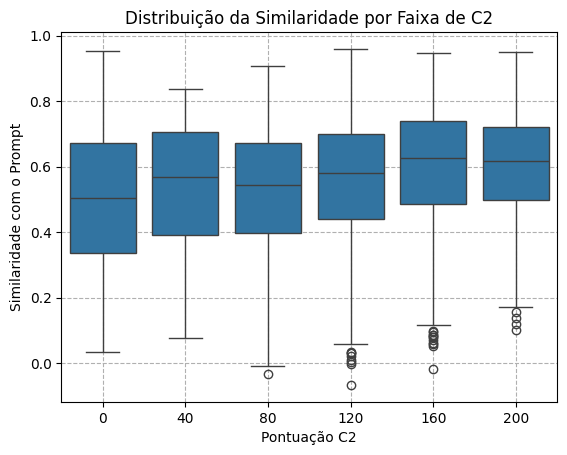

In [ ]:
sns.boxplot(x=train_similarity_df['c2'], y=train_similarity_df['similarity'])
plt.title("Distribuição da Similaridade por Faixa de C2")
plt.ylabel("Similaridade com o Prompt")
plt.xlabel("Pontuação C2")
plt.grid(True, linestyle='--')
plt.savefig('figs/similarity_by_c2_boxplot.png')
plt.show()


## Uso de repertório sociocultural produtivo

REN para identifcação de menções a pessoas, organizações, obras e eventos históricos e computação do número de repertórios.

"Presença de repertório sociocultural, que se configura como uma informação, um fato, uma citação ou uma experiência vivida que, de alguma forma, contribua como argumento para a discussão proposta".

In [ ]:
import spacy
from utils2 import extract_named_entities_spacy, extract_custom_repertoire

train_entity_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'dfs', 'train_entity_spacy-custom.csv')
spacy_model_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'models', 'spacy_model.joblib')

if (os.path.exists(train_entity_path) and
    os.path.exists(spacy_model_path)):

    print("Modelos e arquivos salvos encontrados!")
    print("Carregando modelo spacy...")
    spacy_model = joblib.load(spacy_model_path)
    print("Modelo carregado com sucesso!")

    print(f"Carregando arquivo de entidade nomeadas...")
    train_entity_df = pd.read_csv(train_entity_path)
    print("Arquivo carregado!")

else:
  print("Sem modelos ou arquivos salvos. Construíndo agora...")
  # Carregar o modelo spaCy para português
  try:
    spacy_model = spacy.load("pt_core_news_md")
  except OSError:
    print("Modelo 'pt_core_news_md' não encontrado. Baixando e instalando...")
    spacy.cli.download("pt_core_news_md")
    spacy_model = spacy.load("pt_core_news_md")
  finally:
    # Salvar modelo
    joblib.dump(spacy_model, spacy_model_path)

  train_entity_df = train_df.copy()

  # Aplicar a função para extrair entidades de cada redação
  print("Identificando entidades nomeadas (spaCy) no corpus de treino...")
  train_entity_df['spacy_ent'] = train_entity_df['essay_text'].apply(
    lambda x: extract_named_entities_spacy(x, spacy_model)
  )
  print("Entidades nomeadas (spaCy) identificadas!")

  # Aplicar as funções para extrair repertório customizado
  print("Identificando repertório customizado no corpus de treino...")
  train_entity_df['custom_ent'] = train_entity_df['essay_text'].apply(
    lambda x: extract_custom_repertoire(x)
  )

  # Concatenar todas as entidades (spaCy + customizadas) para uma contagem total
  train_entity_df['all_entities'] = train_entity_df.apply(
    lambda row: row['spacy_ent'] +
                [(item, "CUSTOM_ENT") for item in row['custom_ent']],
    axis=1
  )
  print("Repertório customizado identificado!")

  # Contar o número de entidades reconhecidas (agora incluindo customizadas)
  print("Calculando número de entidades por redação...")
  train_entity_df['num_entities'] = train_entity_df['all_entities'].apply(len)
  print("Número de entidades por redação calculado!")

  # Salvar df
  train_entity_df.to_csv(train_entity_path, index=False) # Use a variável de caminho
  print(f"DataFrame salvo em: {train_entity_path}")



Modelos e arquivos salvos encontrados!
Carregando modelo spacy...
Modelo carregado com sucesso!
Carregando arquivo de entidade nomeadas...
Arquivo carregado!


In [ ]:
pd.set_option('display.max_colwidth', None)  # pra ver o conteúdo completo das células
display(train_entity_df[['spacy_ent','custom_ent','num_entities', 'c2']].head(10))
pd.reset_option('display.max_colwidth')

,spacy_ent,custom_ent,num_entities,c2
0,"[('organização mundial da saúde(OMS', 'ORG')]",[],1,120
1,"[('Transtorno de Ansiedade', 'LOC'), ('Ministério da Saúde', 'LOC')]",[],2,160
2,[],"['Direitos Humanos', 'Declaração Universal dos Direitos Humanos']",2,160
3,"[('Barão de Itararé', 'PER'), ('Brasil', 'LOC'), ('Peter', 'PER'), ('Brasil', 'LOC'), ('Ministério', 'LOC'), ('Barão de Itararé', 'PER')]",[],6,160
4,"[('União', 'LOC'), ('Ilha do Governador', 'LOC'), ('Estados Unidos da América', 'LOC'), ('Andressa Urach', 'PER'), ('vice miss bumbum', 'ORG')]",['Consumismo'],6,160
5,[],[],0,120
6,"[('Museu Nacional do Rio de Janeiro', 'LOC'), ('Miguel Cervantes', 'PER'), ('Museu Nacional', 'LOC')]",['O Capital'],4,120
7,"[('Tânia Garcia', 'PER'), ('João Pedro', 'PER'), ('Ministério da Educação', 'LOC')]",['Democracia'],4,160
8,[],[],0,80
9,"[('Estar', 'LOC'), ('Rafa Kalimann', 'PER')]",['Cultura do Cancelamento'],3,160


Identificar se as entidades dos textos motivadores foram utilizados

Talvez utilizar similaridade para determinar se as entidades encontradas são produtivas para o tema da redação.

### Análise da abordagem


In [ ]:
# --- Correlação entre o número de entidade e pontuação da C2 ---
correlation_c2_num_entities = train_entity_df['num_entities'].corr(train_entity_df['c2'])
print(f"Correlação entre número de entidades identificadas (spaCy + customizadas) e C2: {correlation_c2_num_entities}")


Correlação entre número de entidades identificadas (spaCy + customizadas) e C2: 0.30609686979481526


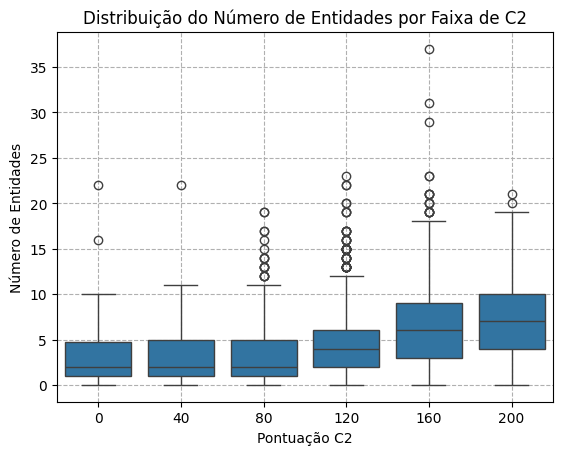

In [ ]:
# --- Visualização: Box Plot por Pontuação C2 ---
sns.boxplot(x='c2', y='num_entities', data=train_entity_df, order=sorted(train_entity_df['c2'].unique()))
plt.title('Distribuição do Número de Entidades por Faixa de C2')
plt.xlabel('Pontuação C2')
plt.ylabel('Número de Entidades')
plt.grid(True, linestyle='--')
plt.savefig('figs/num_entities_spacy-custom_by_c2_boxplot.png')
plt.show()

O modelo pt_core_news_md classifica algumas entidades erroneamente como LOC ao invés de ORG por ex. Enquanto o pt_core_news_sm parece errar com menos frequência.

# Pontuação C2

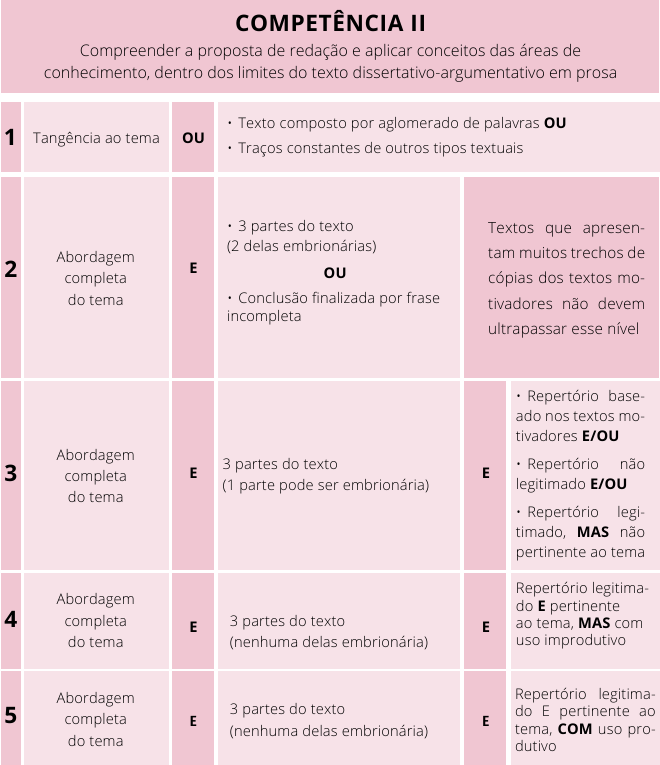

A **tangência ao tema** caracteriza-se por uma abordagem incompleta dos elementos
relacionados a ele.

Há **partes embrionárias** no texto dissertativo-argumentativo quando a introdução, a argumentação E/OU a conclusão são muito curtas devido a sua pouca produção.

O **repertório sociocultural** configura-se como toda e qualquer informação, fato, citação ou experiência vivida que, de alguma forma, contribui como argumento para a discussão proposta pelo participante.
Alguns argumentos que podem caracterizar o repertório esperado são: provas concretas (dados ou fatos sobre o tema), exemplos (fatos similares ou relacionados ao tema), autoridades (citação de especialistas no tema), lógica (causa e consequência, por exemplo) e senso comum (o que as pessoas em geral pensam sobre o tema).

Garanta que todos os modelos necessários estejam carregados/treinados:

- `sbert_model` (para similaridade)
- `tfidf_vectorizer_similarity` e `tfidf_vectorizer_genre` (para similaridade e gênero)
- `classifier_model_genre` (para gênero)
- `scaler_model_genre` (para gênero)
- `spacy_model` (para entidades spaCy)

In [ ]:
try:
  print("Carregando modelos...")
  sbert_model = joblib.load('models/sbert_model.joblib')
  tfidf_vectorizer_similarity = joblib.load('models/tfidf_vectorizer_similarity.joblib')
  tfidf_vectorizer_genre = joblib.load('models/tfidf_vectorizer_genre.joblib')
  classifier_model_genre = joblib.load('models/classifier_model_genre.joblib')
  scaler_model_genre = joblib.load('models/scaler_model_genre.joblib')
  spacy_model = joblib.load('models/spacy_model.joblib')
  print("Todos os modelos foram carregados com sucesso!")
except Exception as e:
  print(f"Erro ao carregar os modelos: {e}")

Carregando modelos...
Todos os modelos foram carregados com sucesso!


## Extração de features

Com base nas abordagens mencionadas para cada aspecto, a função `c2_features` calcula, para uma redação, os valores de `similarity_score`, `prob_dissertativo`, e `num_entities`.

O cálculo desses atributos é realizado em todas as redações do conjunto (train, valid e test), a fim de treinar um modelo de classificação.


In [ ]:
from utils2 import extract_top_keywords_tfidf, calculate_similarity, extract_named_entities_spacy, extract_custom_repertoire

def c2_features(
    title: str,
    description: str,
    essay: list,
) -> dict:
  """
  Mapeia os resultados dos aspectos da Competência 2 para uma pontuação do Enem (0, 40, 80, 120, 160, 200).

  Args:
      title (str): Título do texto motivador.
      description (str): Texto motivador.
      essay (list): Lista de parágrafos da redação.
  Returns:
      (dict):
          similarity_score: Pontuação de similaridade.
          prob_dissertativo: Probabilidade de ser dissertativo.
          num_entities: Número de entidades identificadas.
  """

  features = {
      "similarity_score": 0.0,
      "prob_dissertativo": 0.0,
      "num_entities": 0
  }

  # --- 0. PREPROCESSAMENTO ---
  essay_text = ' '.join(essay)

  # --- 1. CARREGAR MODELOS E VETORIZADORES UTILIZADOS ---
  # sbert_model = joblib.load('models/sbert_model.joblib')
  # tfidf_vectorizer_similarity = joblib.load('models/tfidf_vectorizer_similarity.joblib')
  # tfidf_vectorizer_genre = joblib.load('models/tfidf_vectorizer_genre.joblib')
  # classifier_model = joblib.load('models/classifier_model.joblib')
  # scaler_model = joblib.load('models/scaler_model.joblib')
  # spacy_model = joblib.load('models/spacy_model.joblib')



  # --- 2. COBERTURA DO TEMA (SIMILARIDADE) ---
  # 2.1 Extrair palavras-chave da redação
  essay_keywords = extract_top_keywords_tfidf(essay_text, tfidf_vectorizer_similarity, top_n=10)
  prompt_text = title + " " + description
  prompt_keywords = extract_top_keywords_tfidf(prompt_text, tfidf_vectorizer_similarity, top_n=10)
  # 2.2 Calcular a similaridade
  features["similarity_score"] = calculate_similarity(essay_keywords, prompt_keywords, sbert_model)



  #  --- 3. ADEQUAÇÃO AO GÊNERO (CLASSIFICADOR) ---
  # 3.1 Extrair características customizadas (numéricas)
  num_paragraphs = len(essay)
  paragraph_lengths = [len(p.split()) for p in essay]
  avg_paragraph_length = np.mean(paragraph_lengths)
  additional_features_single_essay = np.array([[num_paragraphs, avg_paragraph_length]])
  # 3.2 Escalar as características numéricas
  scaled_additional_features = scaler_model_genre.transform(additional_features_single_essay)
  # 3.3 Vetorizar o texto com TF-IDF
  essay_vec = tfidf_vectorizer_genre.transform([essay_text])
  # 3.4 Combinar as características (TF-IDF esparso com numéricas escaladas)
  combined_features_single_essay = hstack([essay_vec, scaled_additional_features])

  # 3.5 Prever a probabilidade
  features["prob_dissertativo"] = classifier_model_genre.predict_proba(combined_features_single_essay)[0][1]



  # --- 4. USO DE REPERTÓRIO (NER) ---
  # 4.1 Extrair entidades spaCy
  named_entities_spacy = extract_named_entities_spacy(essay_text, spacy_model)
  # 4.2 Extrair repertório customizado
  custom_entities = extract_custom_repertoire(essay_text)
  # 4.3 Concatenar todas as entidades (mais p calc a len)
  all_entities = named_entities_spacy + \
                  [(item, "CUSTOM_ENT") for item in custom_entities]
  features["num_entities"] = len(all_entities)


  return features

Extraíndo/calculando atributos de todas as redações no dataset:

In [ ]:
if (os.path.exists('dfs/train_features.csv') and
    os.path.exists('dfs/valid_features.csv') and
    os.path.exists('dfs/test_features.csv')):
  train_features = pd.read_csv('dfs/train_features.csv')
  valid_features = pd.read_csv('dfs/valid_features.csv')
  test_features = pd.read_csv('dfs/test_features.csv')
  print("Todos os dataframes com as features calculadas foram carregados com sucesso!")
else:
  print("Os dataframes com as features calculadas não foram encontrados. Calculando agora...")
  train_features = train_df.copy()
  valid_features = valid_df.copy()
  test_features = test_df.copy()


  print("Calculando features para o conjunto train...")
  all_similarity_scores = []
  all_prob_dissertativos = []
  all_num_entities = []
  for index, row in train_features.iterrows():
    prompt_id = row['prompt']
    current_prompt = prompts_df.loc[prompt_id]
    features = c2_features(
        title=current_prompt['title'],
        description=current_prompt['description'],
        essay=row['essay']
    )
    all_similarity_scores.append(features['similarity_score'])
    all_prob_dissertativos.append(features['prob_dissertativo'])
    all_num_entities.append(features['num_entities'])
  print("Cálculo finalizado!")
  train_features['similarity_score'] = all_similarity_scores
  train_features['prob_dissertativo'] = all_prob_dissertativos
  train_features['num_entities'] = all_num_entities

  print("Calculando features para o conjunto valid...")
  all_similarity_scores = []
  all_prob_dissertativos = []
  all_num_entities = []
  for index, row in valid_features.iterrows():
    prompt_id = row['prompt']
    current_prompt = prompts_df.loc[prompt_id]
    features = c2_features(
        title=current_prompt['title'],
        description=current_prompt['description'],
        essay=row['essay']
    )
    all_similarity_scores.append(features['similarity_score'])
    all_prob_dissertativos.append(features['prob_dissertativo'])
    all_num_entities.append(features['num_entities'])
  print("Cálculo finalizado!")
  valid_features['similarity_score'] = all_similarity_scores
  valid_features['prob_dissertativo'] = all_prob_dissertativos
  valid_features['num_entities'] = all_num_entities

  print("Calculando features para o conjunto test...")
  all_similarity_scores = []
  all_prob_dissertativos = []
  all_num_entities = []
  for index, row in test_features.iterrows():
    prompt_id = row['prompt']
    current_prompt = prompts_df.loc[prompt_id]
    features = c2_features(
        title=current_prompt['title'],
        description=current_prompt['description'],
        essay=row['essay']
    )
    all_similarity_scores.append(features['similarity_score'])
    all_prob_dissertativos.append(features['prob_dissertativo'])
    all_num_entities.append(features['num_entities'])
  print("Cálculo finalizado!")
  test_features['similarity_score'] = all_similarity_scores
  test_features['prob_dissertativo'] = all_prob_dissertativos
  test_features['num_entities'] = all_num_entities

  train_features.to_csv('dfs/train_features.csv', index=False)
  valid_features.to_csv('dfs/valid_features.csv', index=False)
  test_features.to_csv('dfs/test_features.csv', index=False)


display(train_features)


Todos os dataframes com as features calculadas foram carregados com sucesso!


,prompt,essay,c2,essay_text,similarity_score,prob_dissertativo,num_entities
0,86,['É notório que as redes sociais estão cada ve...,120,É notório que as redes sociais estão cada vez ...,0.396418,0.522854,1
1,86,['Com o avanço das tecnologias ao redor do mun...,160,Com o avanço das tecnologias ao redor do mundo...,0.728884,0.740468,2
2,47,['A declaração universal dos direitos humanos ...,160,A declaração universal dos direitos humanos af...,0.598655,0.787989,2
3,89,"['Barão de Itararé, um dos criadores do jornal...",160,"Barão de Itararé, um dos criadores do jornalis...",0.086340,0.850091,6
4,40,"['No carnaval deste ano, a escola de samba Uni...",160,"No carnaval deste ano, a escola de samba União...",0.249176,0.971107,6
...,...,...,...,...,...,...,...
4590,94,['Sabe-se que a educação é indispensável para ...,160,Sabe-se que a educação é indispensável para a ...,0.792032,0.658690,6
4591,15,['Uma das grandes preocupações mundiais da atu...,200,Uma das grandes preocupações mundiais da atual...,0.443860,0.617947,3
4592,95,['De acordo com o iluminista e contratualista ...,120,De acordo com o iluminista e contratualista Je...,0.639077,0.829775,12
4593,87,"['No filme francês ""Cuties"" a protagonista é a...",120,"No filme francês ""Cuties"" a protagonista é adm...",0.477022,0.266280,5


## Classificador

Treinamento inicial e avaliação de classificador:

In [ ]:
X_train = train_features[['similarity_score', 'prob_dissertativo', 'num_entities']]
y_train = train_features['c2']

X_valid = valid_features[['similarity_score', 'prob_dissertativo', 'num_entities']]
y_valid = valid_features['c2']

X_test = test_features[['similarity_score', 'prob_dissertativo', 'num_entities']]
y_test = test_features['c2']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_model_score_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'models', 'scaler_model_score.joblib')

if os.path.exists(scaler_model_score_path):

  print("Scaler treinado encontrado!")
  print("Carregando scaler...")
  scaler_model_score = joblib.load(scaler_model_score_path)
  print("Scaler carregado com sucesso!")

else:
  print("Scaler não encontrado. Treinando agora...")
  # Treinar scaler
  scaler_model_score = StandardScaler()
  scaler_model_score.fit(X_train)

  # Salvar scaler
  joblib.dump(scaler_model_score, scaler_model_score_path)

Scaler treinado encontrado!
Carregando scaler...
Scaler carregado com sucesso!


--- Avaliando KNN ---
Melhores parâmetros: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}


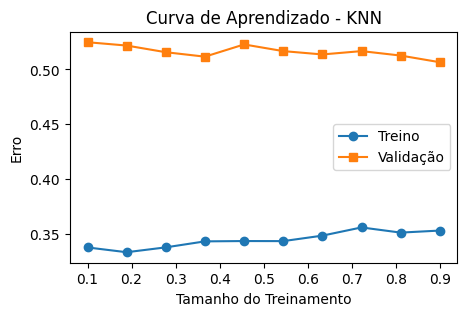

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Acurácia: 0.4934

Matriz de confusão:
[[  0   0   4  14   2   0]
 [  0   0   7   8   2   0]
 [  0   0  45  77  13   1]
 [  0   0  53 198 110   3]
 [  0   0  15  97 236  10]
 [  0   0   2  17  65   8]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
          40       0.00      0.00      0.00        17
          80       0.36      0.33      0.34       136
         120       0.48      0.54      0.51       364
         160       0.55      0.66      0.60       358
         200       0.36      0.09      0.14        92

    accuracy                           0.49       987
   macro avg       0.29      0.27      0.27       987
weighted avg       0.46      0.49      0.47       987

--- Avaliando Naive Bayes ---


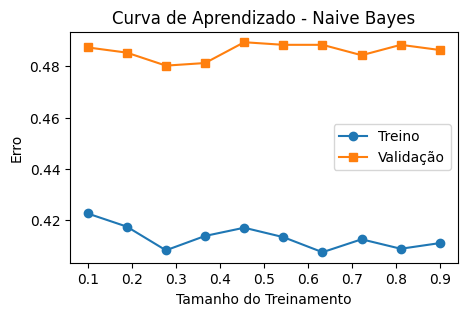

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Acurácia: 0.5137

Matriz de confusão:
[[  0   0   4  14   2   0]
 [  0   0   4  11   2   0]
 [  0   0  16 103  17   0]
 [  0   0  14 242 108   0]
 [  0   0   4 105 249   0]
 [  0   0   1  17  74   0]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
          40       0.00      0.00      0.00        17
          80       0.37      0.12      0.18       136
         120       0.49      0.66      0.57       364
         160       0.55      0.70      0.61       358
         200       0.00      0.00      0.00        92

    accuracy                           0.51       987
   macro avg       0.24      0.25      0.23       987
weighted avg       0.43      0.51      0.46       987

--- Avaliando Logistic Regression ---


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

Melhores parâmetros: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}


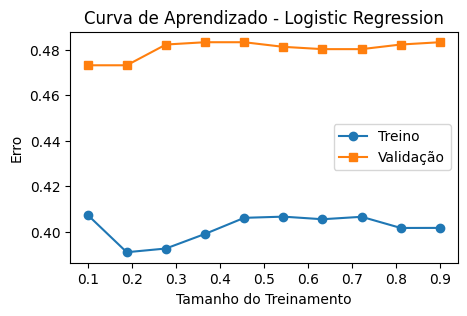

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Acurácia: 0.5167

Matriz de confusão:
[[  0   0   3  15   2   0]
 [  0   0   3  12   2   0]
 [  0   0   6 115  15   0]
 [  0   0   4 251 109   0]
 [  0   0   0 105 253   0]
 [  0   0   0  20  72   0]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
          40       0.00      0.00      0.00        17
          80       0.38      0.04      0.08       136
         120       0.48      0.69      0.57       364
         160       0.56      0.71      0.62       358
         200       0.00      0.00      0.00        92

    accuracy                           0.52       987
   macro avg       0.24      0.24      0.21       987
weighted avg       0.43      0.52      0.45       987

--- Avaliando Random Forest ---
Melhores parâmetros: {'class_weight': None, 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


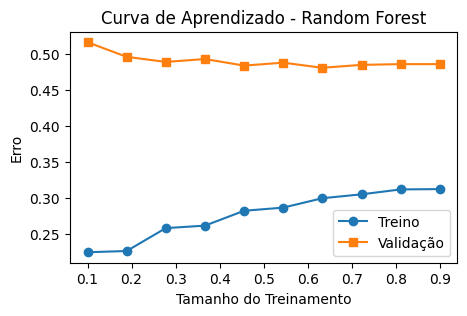


Acurácia: 0.5147

Matriz de confusão:
[[  0   0   3  14   3   0]
 [  0   0   5  10   2   0]
 [  0   0  25  94  17   0]
 [  0   0  17 225 121   1]
 [  0   0   3  96 255   4]
 [  0   0   0  18  71   3]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
          40       0.00      0.00      0.00        17
          80       0.47      0.18      0.26       136
         120       0.49      0.62      0.55       364
         160       0.54      0.71      0.62       358
         200       0.38      0.03      0.06        92

    accuracy                           0.51       987
   macro avg       0.31      0.26      0.25       987
weighted avg       0.48      0.51      0.47       987



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from utils2 import avaliar_modelos

param_grids = {
    "KNN": {
        "n_neighbors": [3, 5, 7],
        "metric": ['euclidean', 'manhattan', 'minkowski'],
        "weights": ["uniform", "distance"]
    },
    "Naive Bayes": {},
    "Logistic Regression": {
        "C": [0.1, 1, 10],
        "solver": ["lbfgs", "liblinear"],
        "penalty": ["l1", "l2"],
        "class_weight": ["balanced", None]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "class_weight": ["balanced", None]
    }
    # "Gradient Boosting": {
    #     "n_estimators": [100, 200, 500],
    #     "learning_rate": [0.01, 0.1, 0.2],
    #     "max_depth": [3, 5, 7]
    # }
}

models = {
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
    # "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = avaliar_modelos(models, param_grids, X_train_scaled, y_train, X_valid_scaled, y_valid)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

classifier_model_score_path = os.path.join(GOOGLE_DRIVE_PATH_PROJETO, 'models', 'classifier_model_score.joblib')

X_train_scaled = scaler_model_score.transform(X_train)
X_valid_scaled = scaler_model_score.transform(X_valid)
X_test_scaled = scaler_model_score.transform(X_test)

# --- 1. TREINAMENTO ---
print("Treinando classificador...")
classifier_model_score = LogisticRegression(
    random_state=42,
    penalty='l2',
    C=1,
    class_weight=None,
    solver='lbfgs',
    max_iter=1000)
classifier_model_score.fit(X_train_scaled, y_train)
print("Treino concluído!")

# Salvar modelo de classificação
joblib.dump(classifier_model_score, classifier_model_score_path)

# --- 2. AVALIAÇÃO ---
datasets = {
  "Treino": (X_train_scaled, y_train),
  "Validação": (X_valid_scaled, y_valid),
  "Teste": (X_test_scaled, y_test)
}

for name, (X, y) in datasets.items():
  print(f"\n--- {name} ---")
  y_pred = classifier_model_score.predict(X)
  accuracy = accuracy_score(y, y_pred)
  print(f"Acurácia: {accuracy:.4f}")

  print("Relatório de classificação:")
  target_names = [str(score) for score in sorted(y_train.unique())]
  print(classification_report(y, y_pred, target_names=target_names, zero_division=0))

  print("Matriz de confusão:")
  cm = confusion_matrix(y, y_pred, labels=sorted(y_train.unique()))
  print(cm)

Treinando classificador...
Treino concluído!

--- Treino ---
Acurácia: 0.5978
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
          40       0.00      0.00      0.00        58
          80       0.53      0.08      0.13       659
         120       0.55      0.79      0.65      1714
         160       0.66      0.79      0.72      1689
         200       0.00      0.00      0.00       389

    accuracy                           0.60      4595
   macro avg       0.29      0.28      0.25      4595
weighted avg       0.52      0.60      0.53      4595

Matriz de confusão:
[[   0    0    5   74    7    0]
 [   0    0    8   42    8    0]
 [   0    0   50  575   34    0]
 [   0    0   31 1356  327    0]
 [   0    0    0  348 1341    0]
 [   0    0    0   61  328    0]]

--- Validação ---
Acurácia: 0.5218
Relatório de classificação:
              precision    recall  f1-score   support

           0 